# Using PyMC3

PyMC3 is a Python package for doing MCMC using a variety of samplers, including Metropolis, Slice and Hamiltonian Monte Carlo. See [Probabilistic Programming in Python using PyMC](http://arxiv.org/abs/1507.08050) for a description. The GitHub [site](https://github.com/pymc-devs/pymc3) also has many examples and links for further exploration.

In [1]:
! pip install --quiet pymc3[plots]
! pip install --quiet daft
! pip install --quiet seaborn

In [2]:
! conda install --yes --quiet mkl-service

/bin/sh: conda: command not found


In [3]:
import warnings

warnings.simplefilter('ignore', UserWarning)

**Other resources**

Some examples are adapted from:

- [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [MCMC tutorial series](https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/)

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft
import arviz as az

In [6]:
import theano
theano.config.warn.round=False

## Introduction to PyMC3

### Distributions in pymc3

In [7]:
print(', '.join([d for d in dir(pm.distributions) if d[0].isupper()]))

AR, AR1, Bernoulli, Beta, BetaBinomial, Binomial, Bound, Categorical, Cauchy, ChiSquared, Constant, ConstantDist, Continuous, DensityDist, Dirichlet, Discrete, DiscreteUniform, DiscreteWeibull, Distribution, ExGaussian, Exponential, Flat, GARCH11, Gamma, GaussianRandomWalk, Geometric, Gumbel, HalfCauchy, HalfFlat, HalfNormal, HalfStudentT, Interpolated, InverseGamma, KroneckerNormal, Kumaraswamy, LKJCholeskyCov, LKJCorr, Laplace, Logistic, LogitNormal, Lognormal, MatrixNormal, Mixture, Multinomial, MvGaussianRandomWalk, MvNormal, MvStudentT, MvStudentTRandomWalk, NegativeBinomial, NoDistribution, Normal, NormalMixture, OrderedLogistic, Pareto, Poisson, Rice, SkewNormal, StudentT, TensorType, Triangular, TruncatedNormal, Uniform, VonMises, Wald, Weibull, Wishart, WishartBartlett, ZeroInflatedBinomial, ZeroInflatedNegativeBinomial, ZeroInflatedPoisson


In [8]:
d = pm.Normal.dist(mu=0, sd=1)

In [9]:
d.dist()

Random samples

In [10]:
d.random(size=5)

array([-0.13800316, -0.72664541, -1.27534009,  1.56942182,  0.42454202])

Log probability

In [11]:
d.logp(0).eval()

array(-0.91893853)

#### Custom distributions

The pymc3 algorithms generally only work with the log probability of a distribution. Hence it is easy to define custom distributions to use in your models by providing a `logp` function.

In [12]:
def logp(x, μ=0, σ=1):
    """Normal distribtuion."""
    return -0.5*np.log(2*np.pi) - np.log(σ) - (x-μ)**2/(2*σ**2)

In [13]:
d = pm.DensityDist.dist(logp)

In [14]:
d.logp(0)

-0.9189385332046727

## Example: Estimating coin bias

We start with the simplest model - that of determining the bias of a coin from observed outcomes.

### Setting up the model    

In [15]:
n = 100
heads = 61

#### Analytical solution

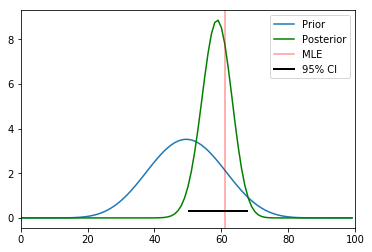

In [16]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), c='green', label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()
pass

#### Graphical model

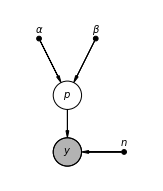

In [17]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
pass

### The Model context

When you specify a model, you are adding nodes to a computation graph. When executed, the graph is compiled via Theno. Hence, `pymc3` uses the Model context manager to automatically add new nodes.

In [18]:
niter = 2000
with pm.Model() as coin_context:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4106.41draws/s]


In [19]:
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, progressbar=True, model=None, random_seed=None, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
        by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables without a step methods,
        step methods for those variables will be assigned automatically.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto : Cho

### Specifying sampler (step) and multiple chains

In [20]:
with coin_context:
    step = pm.Metropolis()
    t = pm.sample(niter, step=step, chains=8, random_seed=123)

Multiprocess sampling (8 chains in 4 jobs)
Metropolis: [p]
Sampling 8 chains: 100%|██████████| 20000/20000 [00:03<00:00, 5399.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### MAP estimate

In [21]:
with pm.Model() as m:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    θ = pm.find_MAP()

/usr/local/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -4.5407, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 1651.08it/s]


In [22]:
θ

{'p_logodds__': array(0.43825493), 'p': array(0.60784314)}

#### Getting values from the trace

In [23]:
p = trace.get_values('p')
p.shape

(8000,)

In [24]:
trace['p'].shape

(8000,)

#### Convert to `pandas` data frame for downstream processing

In [25]:
df = pm.trace_to_dataframe(trace)
df.head()

,p
0,0.604148
1,0.579900
2,0.650230
3,0.607678
4,0.635873


#### Posterior distribution

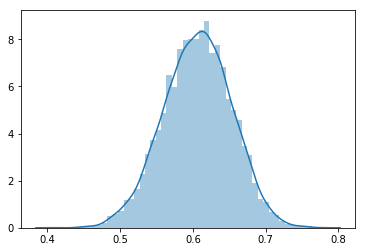

In [26]:
sns.distplot(trace['p'])
pass

#### Autocorrelation plot

/usr/local/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


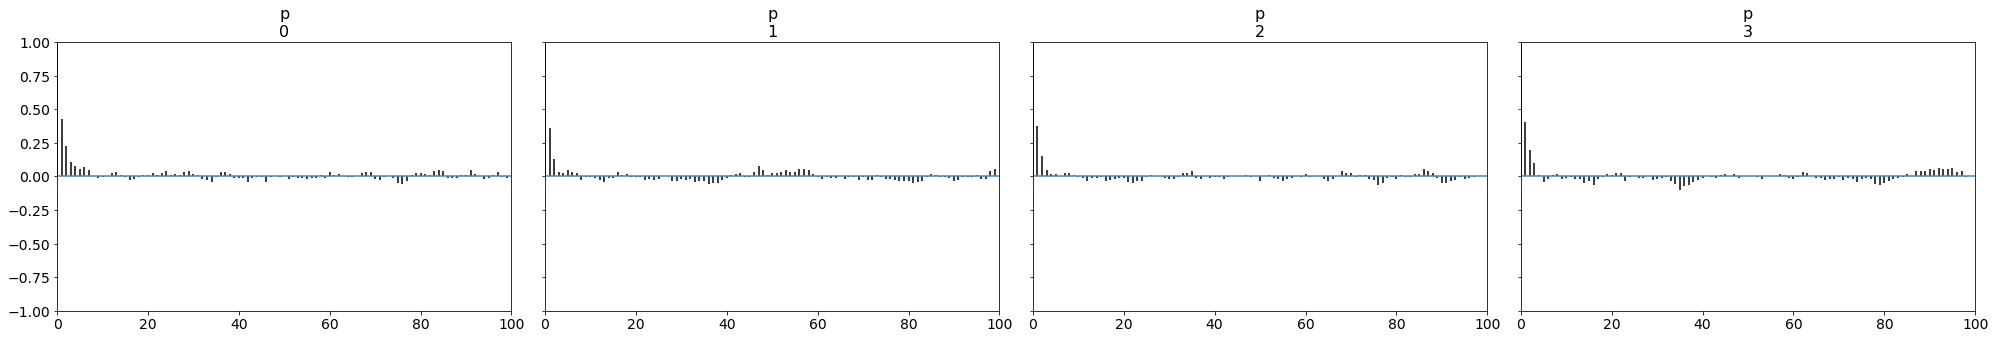

In [27]:
pm.autocorrplot(trace, varnames=['p'])
pass

#### Calculate effective sample size

$$
\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
$$

where $m$ is the number of chains, $n$ the number of steps per chain, $T$ the time when the autocorrelation first becomes negative, and $\hat{\rho}_t$ the autocorrelation at lag $t$.

In [28]:
pm.effective_n(trace)

{'p': 3193.6766606187175}

## Evaluate convergence

##### Gelman-Rubin

$$
\hat{R} = \frac{\hat{V}}{W}
$$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate for the pooled traces.  Values greater than one indicate that one or more chains have not yet converged.

Discrad burn-in steps for each chain. The idea is to see if the starting values of each chain come from the same distribution as the stationary state. 

- $W$ is the number of chains $m \times$ the variacne of each individual chain
- $B$ is the number of steps $n \times$ the variance of the chain means
- $\hat{V}$ is the weigthed average $(1 - \frac{1}{n})W + \frac{1}{n}B$

The idea is that $\hat{V}$ is an unbiased estimator of $W$ if the starting values of each chain come from the same distribution as the stationary state. Hence if $\hat{R}$ differs significantly from 1, there is probsbly no convergence and we need more iterations. This is done for each parameter $\theta$.

In [29]:
pm.gelman_rubin(t)

{'p': 1.002304348425302}

##### Geweke

Compares mean of initial with later segments of a trace for a parameter. Should have absolute value less than 1 at convergence.

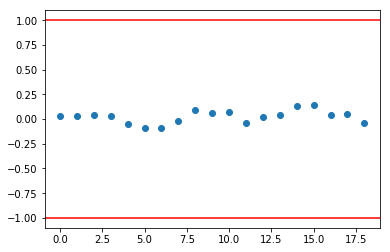

In [30]:
plt.plot(pm.geweke(t['p'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)
pass

#### Textual summary

In [31]:
pm.summary(trace, varnames=['p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.606269,0.046672,0.000759,0.507976,0.690266,3193.676661,1.000376


#### Visual summary

/usr/local/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


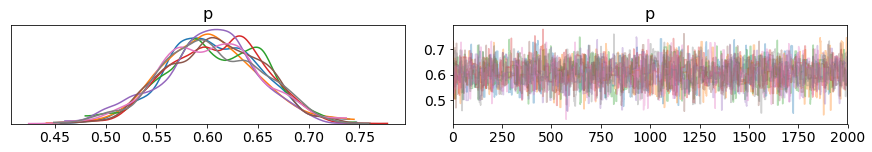

In [32]:
pm.traceplot(t, varnames=['p'])
pass

#### Prior predictive samples

In [33]:
with coin_context:
    ps = pm.sample_prior_predictive(samples=1000)

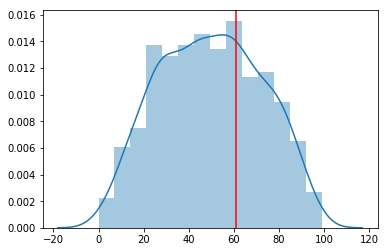

In [34]:
sns.distplot(ps['y'])
plt.axvline(heads, c='red')
pass

#### Posterior predictive samples

In [35]:
with coin_context:
    ps = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3178.72it/s]


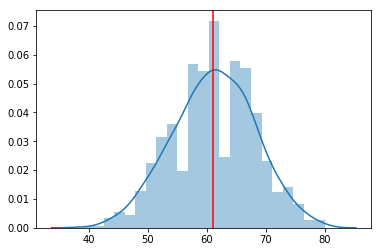

In [36]:
sns.distplot(ps['y'])
plt.axvline(heads, c='red')
pass

## Saving traces

In [37]:
pm.save_trace(trace, 'my_trace', overwrite=True)

'my_trace'

You need to re-initialize the model when reloading.

In [38]:
with pm.Model() as my_trace:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    tr = pm.load_trace('my_trace')

In [39]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.606269,0.046672,0.000759,0.507976,0.690266,3193.676661,1.000376


It is probably a good practice to make model reuse convenient

In [40]:
def build_model():
    with pm.Model() as m:
        p = pm.Beta('p', alpha=2, beta=2)
        y = pm.Binomial('y', n=n, p=p, observed=heads)
    return m

In [41]:
m = build_model()

In [42]:
with m:
    tr1 = pm.load_trace('my_trace')

In [43]:
pm.summary(tr1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.606269,0.046672,0.000759,0.507976,0.690266,3193.676661,1.000376


## Sampling from prior

Just omit the `observed=` argument.

In [44]:
with pm.Model() as prior_context:
    sigma = pm.Gamma('sigma', alpha=2.0, beta=1.0)
    mu = pm.Normal('mu', mu=0, sd=sigma)
    trace = pm.sample(niter, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5029.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


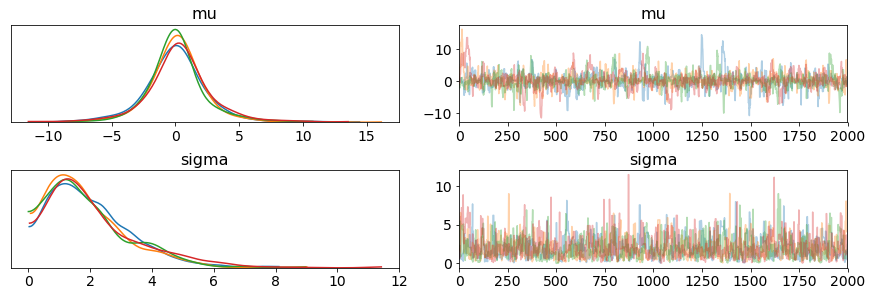

In [45]:
pm.traceplot(trace, var_names=['mu', 'sigma'])
pass

## Sampling from posterior

In [46]:
niter = 2000
with pm.Model() as normal_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3737.51draws/s]
The acceptance probability does not match the target. It is 0.884948479968749, but should be close to 0.8. Try to increase the number of tuning steps.


#### Find Highest Posterior Density (Credible intervals)

In [47]:
hpd = pm.hpd(trace['mu'], alpha=0.05)
hpd

array([0.44250731, 0.55742488])

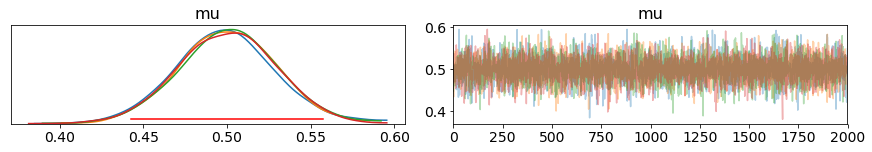

In [48]:
ax = pm.traceplot(trace, var_names=['mu'],)

ymin, ymax = ax[0,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[0, 0].plot(hpd, [y,y], c='red')
pass

## Evaluating goodness-of-fit

DIC, WAIC and BPIC are approximations to the out-of-sample error and can be used for model comparison. Likelihood is dependent on model complexity and should not be used for model comparisons.

In [49]:
post_mean = pm.summary(trace, varnames=trace.varnames)['mean']
post_mean

mu          0.499777
sd_log__   -1.217556
sd          0.296716
Name: mean, dtype: float64

#### Likelihood

In [50]:
normal_context.logp(post_mean)

array(-26.57862273)

#### Cross-validation

In [51]:
with normal_context:
    print(pm.loo(trace))

LOO_r(LOO=40.66725601304151, LOO_se=8.879843471487696, p_LOO=1.3448711801540263, shape_warn=0)


#### WAIC

In [52]:
with normal_context:
    print(pm.waic(trace))

WAIC_r(WAIC=40.666422391175566, WAIC_se=8.879725955631072, p_WAIC=1.3444543692210542, var_warn=0)


## Using a custom likelihood

In [53]:
def logp(x, μ=0, σ=1):
    """Normal distribtuion."""
    return -0.5*np.log(2*np.pi) - np.log(σ) - (x-μ)**2/(2*σ**2)

In [54]:
with pm.Model() as prior_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.DensityDist('y', logp, observed=dict(x=xs, μ=mu, σ=sd))
    custom_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3887.85draws/s]


In [55]:
pm.trace_to_dataframe(custom_trace).mean()

mu    0.500154
sd    0.296953
dtype: float64